In [1]:
# Importing all the necessary libraries

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_holes,remove_small_objects,binary_closing,closing,convex_hull_image
from skimage.morphology import skeletonize, thin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import confusion_matrix,roc_auc_score,f1_score,classification_report
from scipy import stats
from imblearn.over_sampling import SMOTE 
import pandas as pd
import seaborn as sns
import os
from collections import Counter

# All function definitions

In [2]:
# Function definition of image segmentation to separate the potential bacilli objects from image background

def image_segmentation(img):
    
    # Transform the input image to YCbCr color space and calculate the histogram and its first derivative of cr-component 
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img_cr = img_ycrcb[:,:,1]       
    cr_hist,_ = np.histogram(img_cr.ravel(),256,[0,256])
    cr_hist_diff = np.diff(cr_hist)

    # Transform the input image to CIE-Lab color space and calculate the histogram and its first derivative of a-component 
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    img_a = img_lab[:,:,1]
    a_hist,_ = np.histogram(img_a.ravel(),256,[0,256])
    a_hist_diff = np.diff(a_hist)
    
    int_lvls = np.arange(0,255)
    
    # Calculating the segmentation threshold for cr-component based on its difference histogram
    
    # -18000 is the threshold of cr-component for (1200x900) image. So scaling the threshold as per input image dimensions
    cr_hist_th = int(-18000*(orig_img_shape[0]*orig_img_shape[1])/(1200*900))
    if (int_lvls[cr_hist_diff<=cr_hist_th].size!=0):
        cr_th_i = np.max(int_lvls[cr_hist_diff<=cr_hist_th])
    # If there is no pixel intensity below -18000, take threshold as peak of cr histogram
    else:
        cr_th_i = np.argmax(cr_hist)

    # Calculating the segmentation threshold for a-component based on its difference histogram
    
    # -1000 is the threshold of a-component for (1200x900) image. So scaling the threshold as per input image dimensions
    a_hist_th = int(-1000*(orig_img_shape[0]*orig_img_shape[1])/(1200*900))
    if (int_lvls[a_hist_diff<=a_hist_th].size!=0):
        a_th_i = np.max(int_lvls[a_hist_diff<=a_hist_th])
    # If there is no pixel intensity below -1000, take threshold as peak of a-histogram
    else:
        a_th_i = np.argmax(a_hist)

    
    # Thresholding the cr and a components using the above thresholds and calculating their segmented image outputs
    a_th = a_th_i
    cr_th = cr_th_i
    _, img_a_th = cv2.threshold(img_a, a_th, 255, cv2.THRESH_BINARY)
    _, img_cr_th = cv2.threshold(img_cr, cr_th, 255, cv2.THRESH_BINARY)
    
    # Performing logical AND between both the segmented images to get the final segmented image
    img_seg = cv2.bitwise_and(img_cr_th,img_a_th)

    return img_seg

In [3]:
# Function definition of image postprocessing to remove small size artifacts from segmented image

def image_postprocess(img_seg):
    
    # Removing small size artifacts on segmented image
    img_bin1 = (img_seg//255).astype(bool)
    img_rem1 = remove_small_objects(img_bin1,min_size=20,connectivity=8).astype('uint8')*255
    #img_fill = (remove_small_holes(img_rem1,area_threshold=5000,connectivity=8)).astype('uint8')*255
    #img_bin2 = (img_fill//255).astype(bool)
    #img_rem2 = remove_small_objects(img_bin2,min_size=50,connectivity=8).astype('uint8')*255
    img_pp = img_rem1.copy()
    
    return img_pp

In [4]:
# Function definition to assign class label to each image object

def label_image_objects(img_file,annot_fold_path):

    # Finding annotation file path from image file path
    annot_file = img_file[:-4]+'_annot.csv'
    annot_file_path = os.path.join(annot_fold_path,annot_file)

    annot_cols = ["Label","x_st_pt","y_st_pt","box_width","box_height","Image_name","Image_width","Image_height"]

    lbl_data = pd.read_csv(annot_file_path,names=annot_cols)
    
    # Initializtion of labelled image with zero pixel intensities
    img_lbl = np.ones(orig_img_shape[:2], np.uint8)*20

    # Extracting the class label and drawing bounding boxes with different intensities on labelled image
    for i in range(lbl_data.shape[0]):
        x_st_pt = lbl_data["x_st_pt"][i]
        y_st_pt = lbl_data["y_st_pt"][i]
        x_end_pt = x_st_pt+lbl_data["box_width"][i]
        y_end_pt = y_st_pt+lbl_data["box_height"][i]
        if (lbl_data["Label"][i]=="circle"):
            fill_val = 50
        if (lbl_data["Label"][i]=="rectangle"):
            fill_val = 100
        if (lbl_data["Label"][i]=="diamond"):
            fill_val = 150
        if (lbl_data["Label"][i]=="hexagon"):
            fill_val = 200
        st_pt = (x_st_pt,y_st_pt)
        end_pt = (x_end_pt,y_end_pt)
        cv2.rectangle(img_lbl, st_pt, end_pt, fill_val, thickness=-1)
    
    # Resize the labelled image to standard size of 600x800
    img_lbl = cv2.resize(img_lbl,(img_shape[1],img_shape[0]))
    
    # Perform logical AND between post processed image and labelled image to get postprocessed labelled image where each object
    # given different pixel intensities based on its class label
    img_pp_lbl = cv2.bitwise_and(img_pp,img_lbl)
    
    return img_lbl,img_pp_lbl

In [5]:
# Function definition to find contours of objects present on the post processed labelled image

def find_contours(img_pp_lbl):
    
    # Find contours from the post processed labelled image
    contours,_ = cv2.findContours(img_pp_lbl, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
           
    # Threshold of contour area to accept or reject the contour
    area_th = 2000

    # Filtering the contours based on the number of contour points, contour area and its ellipse features
    contours_filt = []
    for cnt in contours:
        if (len(cnt)<5):
            continue
        (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
        area = cv2.contourArea(cnt)
        area_ell = np.pi*ma*MA/4
        if (x>img_shape[1] or x<0 or y>img_shape[0] or y<0 or area<5 or area>area_th):
            continue
        contours_filt.append(cnt)
        
    return contours_filt      

In [6]:
# Function definition to calculate geometric features of a contour

def extract_features(cnt):
    
    # Calculate eccentricity of contour by fitting an ellipse
    (x,y),(ma,MA),angle = cv2.fitEllipse(cnt)
    cnt_centre = (int(x),int(y))
    eccentricity = ma/MA
    
    # Contour perimeter
    perimeter = cv2.arcLength(cnt,True)
    
    # Contour area (in pixels)
    area = cv2.contourArea(cnt)
    
    # Convex hull of contour
    hull = cv2.convexHull(cnt)
    
    # Perimeter of convex hull
    perimeter_hull = cv2.arcLength(hull,True)
    
    # Roughness of contour
    roughness = perimeter/perimeter_hull
    
    # Area of convex hull
    area_hull = cv2.contourArea(hull)
    
    # Relative convex area
    rel_conv_area = area_hull/area
    
    # Circularity
    circularity = (4*np.pi*area)/perimeter**2
    #circularity = (4*np.pi*area)/perimeter_hull**2
    
    # Compactness
    compactness = perimeter**2/(4*np.pi*area)
    
    # Contour Area (in micro meter)
    area_um = area*2.2
    
    # Calculating Aspect ratio by fitting bounding box across the contour
    x,y,w,h = cv2.boundingRect(cnt)
    asp_ratio = w/h
    
    # Gathering all the features
    features = (cnt_centre,area,roughness,rel_conv_area,eccentricity,circularity,compactness,eccentricity)
    
    return features

In [7]:
# Function definition to get class label of the contour based on pixel intensity

def get_class_lbl(img_lbl,cnt_centre):
    if (img_lbl[cnt_centre[1],cnt_centre[0]]==50):
        cls_lbl = "1"
    elif (img_lbl[cnt_centre[1],cnt_centre[0]]==100):
        cls_lbl = "2"
    elif (img_lbl[cnt_centre[1],cnt_centre[0]]==20):
        cls_lbl = "3"
    else:
        cls_lbl = None
    
    return cls_lbl

In [8]:
# Function definition to detect and count the number of single bacillus in a bacilli cluster based on concave points

def count_single_bacillus(cnt):
    
    # Initializing the count of single bacilli in a cluster to 0
    sing_tb_count = 0
    
    # Calculating the Polygon approximated (PA) contour to smoothen the irregularities
    cnt_approx = cv2.approxPolyDP(cnt,0.005*cv2.arcLength(cnt, True),True)
    
    # Calculating the convexhull of PA contour
    hull = cv2.convexHull(cnt_approx, returnPoints=False)
    hull[::-1].sort(axis=0)
    
    # Calculating the concave points using PA approximated contour and 
    defects = cv2.convexityDefects(cnt_approx, hull)
    #print(defects)
    
    # Calculating the contour segments between each pair of consecutive concave points
    if (defects is not None and defects.shape[0]>1):
        st_ind = -1
        #st_ind = 0
        for j in range(st_ind,defects.shape[0]-1):
            ind1 = defects[j,0,2]
            ind2 = defects[j+1,0,2]
            #print(ind1,ind2)
            if (ind1>ind2):
                list1 = list(range(ind1,cnt_approx.shape[0]))
                list2 = list(range(0,ind2+1))
                list_ = list1+list2
                #print(list_)
                cnt_temp1 = cnt_approx[list_]
            else:
                cnt_temp1 = cnt_approx[ind1:ind2+1]
            #print(cnt_temp1)
            img_temp = np.zeros(img_shape, np.uint8)
            img_temp = cv2.drawContours(img_temp, [cnt_temp1], -1, 255, 3)
            contours_temp,_ = cv2.findContours(img_temp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnt_temp2 = contours_temp[0]
            
            # Fitting ellipse to each contour segment
            if (len(cnt_temp2)>=5):
                (x,y),(ma,MA),angle = cv2.fitEllipse(cnt_temp2)
                eccentricity = ma/MA
                area = cv2.contourArea(cnt_temp2)
                #print((eccentricity,area))
                if (eccentricity>0.1 and eccentricity<0.7 and area>50):
                    sing_tb_count+=1
                    
    return sing_tb_count,defects    

# Training part

In [9]:
# Initialization of empty pandas data frame with below columns to store data matrix

cols_data = ['Area', 'Roughness','Relative convex area','Circularity','Compactness','Eccentricity','Class']
data = pd.DataFrame(columns = cols_data)

In [10]:
# Main Folder consisting of image data
main_fold = r"D:\Project\Data\Traing_test_data"

# Image subfolders
folders = ["Mannual_Microscope-2_set1","Mannual_Microscope-2_set2","Mannual_Seg_Microscope-1_set6","Mannual_Seg_Microscope-1_set7"]
# folders = ["Mannual_Microscope-2_set2"]

In [11]:
# Shape to which segmented image to be resized
img_shape = (600,800)

# Iterating over each image of each image subfolder
for folder in folders:
    fold_path = os.path.join(main_fold,folder)
    img_fold_path = os.path.join(fold_path,"Images")
    annot_fold_path = os.path.join(fold_path,"Annotations")
    img_files = os.listdir(img_fold_path)
    
    for img_file in img_files:
        
        # Reading the input image 
        img_file_path = os.path.join(img_fold_path,img_file)
        orig_img = cv2.imread(img_file_path) 
        orig_img_shape = orig_img.shape[0:2] 
        img = orig_img.copy() 
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img_th = cv2.threshold(img_gray,30,255,cv2.THRESH_BINARY_INV)
        img_th_inv = 255-img_th

               
        # Performing image segmentation on input image
        img_seg = image_segmentation(img)
        
        # Bitwise AND between segmented image and grayscale thresholded image to remove any bounding markers
        img_seg = cv2.bitwise_and(img_seg,img_th_inv)
        
        # Resizing the segmented image to standard size of 600x800 for further processing
        img_seg = cv2.resize(img_seg,(img_shape[1],img_shape[0]))
                
        
        # Post processing on the segmented image
        img_pp = image_postprocess(img_seg)
       
        
        # Assigning class labels to each object of the postprocessed image
        img_lbl,img_pp_lbl = label_image_objects(img_file,annot_fold_path)
                
        
        # Finding the contours of objects from the postprocessed labelled image
        contours_filt = find_contours(img_pp_lbl)
                                      
        # Extract the geometric features and get class labels of all the filtered contours
        for cnt in contours_filt:
            features = extract_features(cnt)
            cnt_centre,area,roughness,rel_conv_area,eccentricity,circularity,compactness,eccentricity = features
            cls_lbl = get_class_lbl(img_lbl,cnt_centre)
            
            # Append the features to input dataframe if class label is valid and form the data matrix
            if (cls_lbl):       
                data = data.append({'Area' : area,  'Roughness' : roughness, 'Relative convex area':rel_conv_area, 
                                    'Circularity':circularity, 'Compactness': compactness, 'Eccentricity':eccentricity, 
                                    'Class' : cls_lbl}, ignore_index = True)
            
            # data = data.append({'Area' : area,  'Eccentricity' : eccentricity, 
                                # 'Class' : cls_lbl}, ignore_index = True)              

(2726, 7)


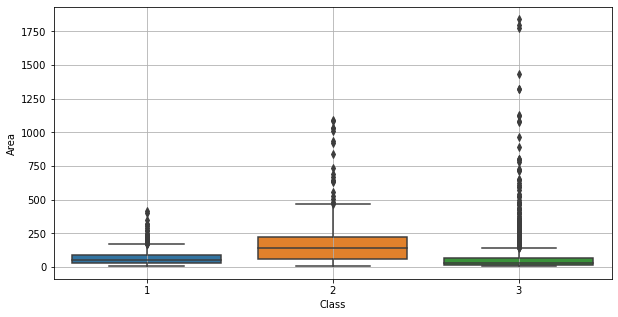

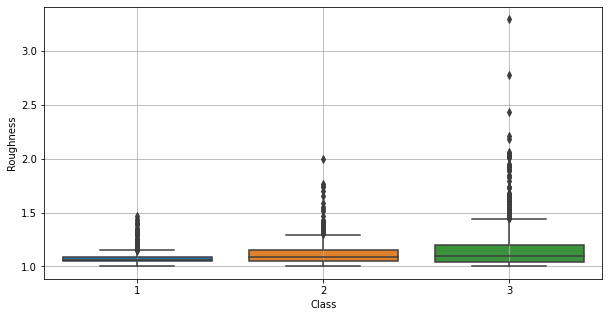

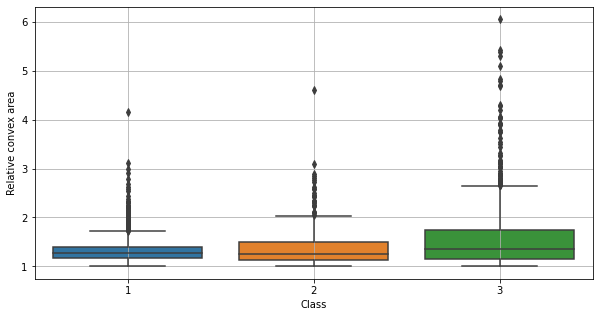

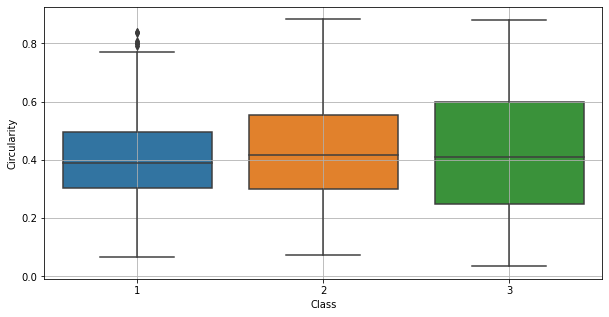

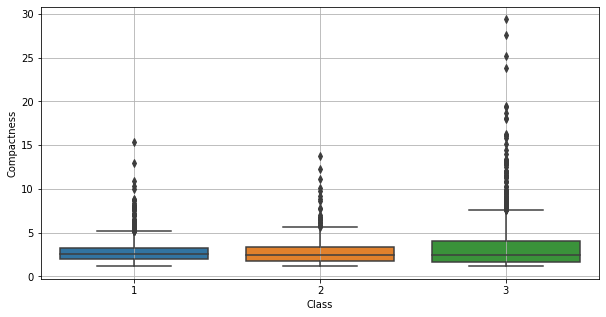

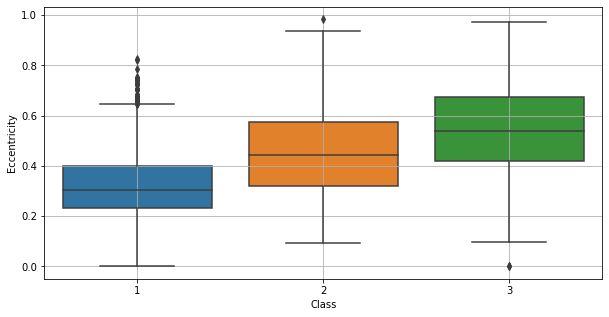

In [12]:
# Plotting the box plots of all the features in input data matrix to visualize the outliers
print(data.shape)
features = data.columns
for col in list(data.columns[:-1]):
    fig,ax=plt.subplots(figsize=(10,5))
    ax = sns.boxplot(x="Class", y=col, data=data, orient='v')
    ax.grid()

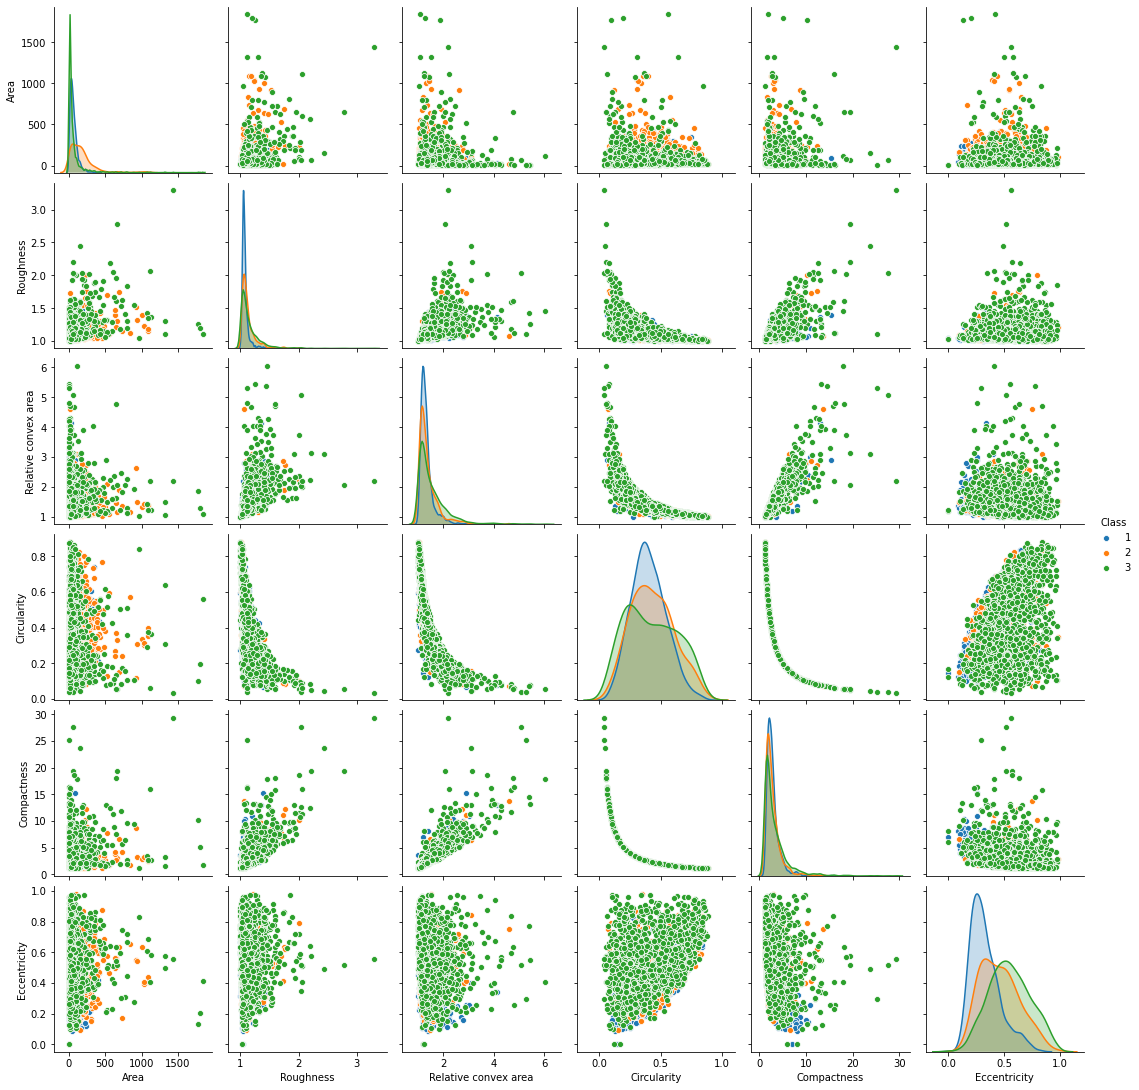

In [13]:
# Plotting pairplot of the input data matrix to observe the separability of classes wrt each feature

sns.pairplot(data,hue="Class")

In [14]:
# Removing the outliers from the input data matrix based on Interquartile range and obtain the filtered data matrix

types = data["Class"].unique()
d = {type: data[data['Class'] == type] for type in types}
d_new = {}
data_filt = pd.DataFrame(columns = cols_data)
for type in types:
    df_temp = d[type]
    Q1 = df_temp.quantile(0.25)
    Q3 = df_temp.quantile(0.75)
    IQR = Q3-Q1
    lower_lim = Q1-1.5*IQR
    upper_lim = Q3+1.5*IQR
    d_new[type] = df_temp[((df_temp.iloc[:,:-1]>=lower_lim)&(df_temp.iloc[:,:-1]<=upper_lim)).all(axis=1)]  
    data_filt = pd.concat([data_filt,d_new[type]])
    
data_filt.drop(["Roughness"],axis=1,inplace=True)    
print(data_filt.shape)
data_filt.head()

(2231, 6)


,Area,Relative convex area,Circularity,Compactness,Eccentricity,Class
0,15.5,1.000000,0.738292,1.354477,0.599371,3
3,12.0,1.291667,0.441305,2.266006,0.469173,3
6,28.5,1.245614,0.501331,1.994691,0.451781,3
7,29.5,1.288136,0.464752,2.151685,0.920482,3
8,13.5,1.629630,0.353733,2.826992,0.493015,3


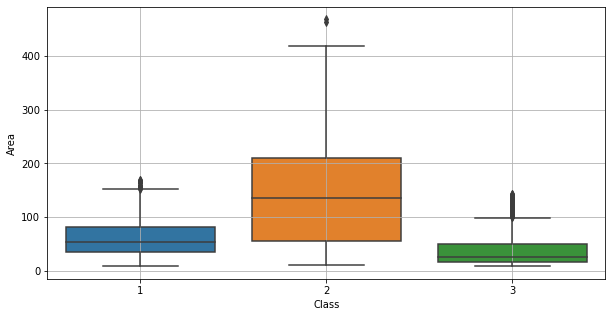

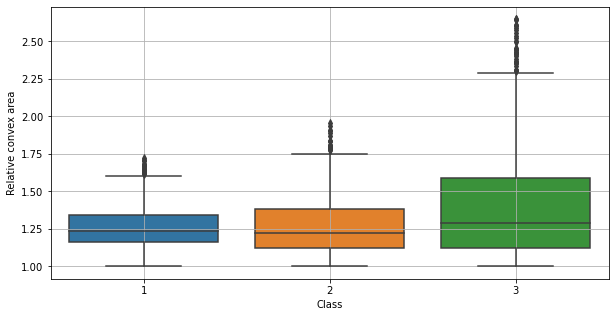

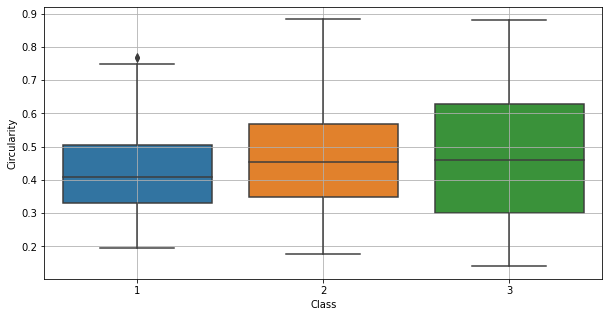

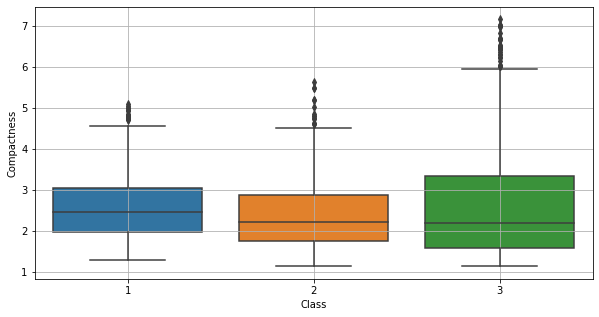

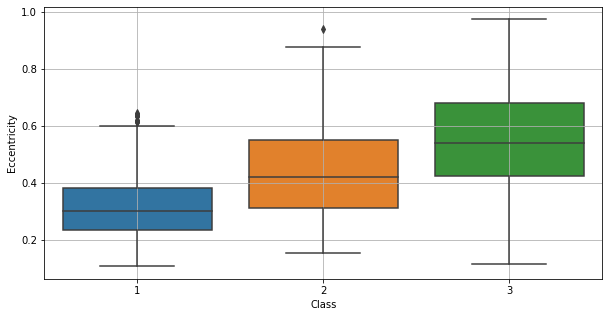

In [15]:
# Plotting the box plots of all the features in filtered data matrix to visualize the outliers

features = data_filt.columns
for col in list(data_filt.columns[:-1]):
    fig,ax=plt.subplots(figsize=(10,5))
    ax = sns.boxplot(x="Class", y=col, data=data_filt, orient='v')
    ax.grid()

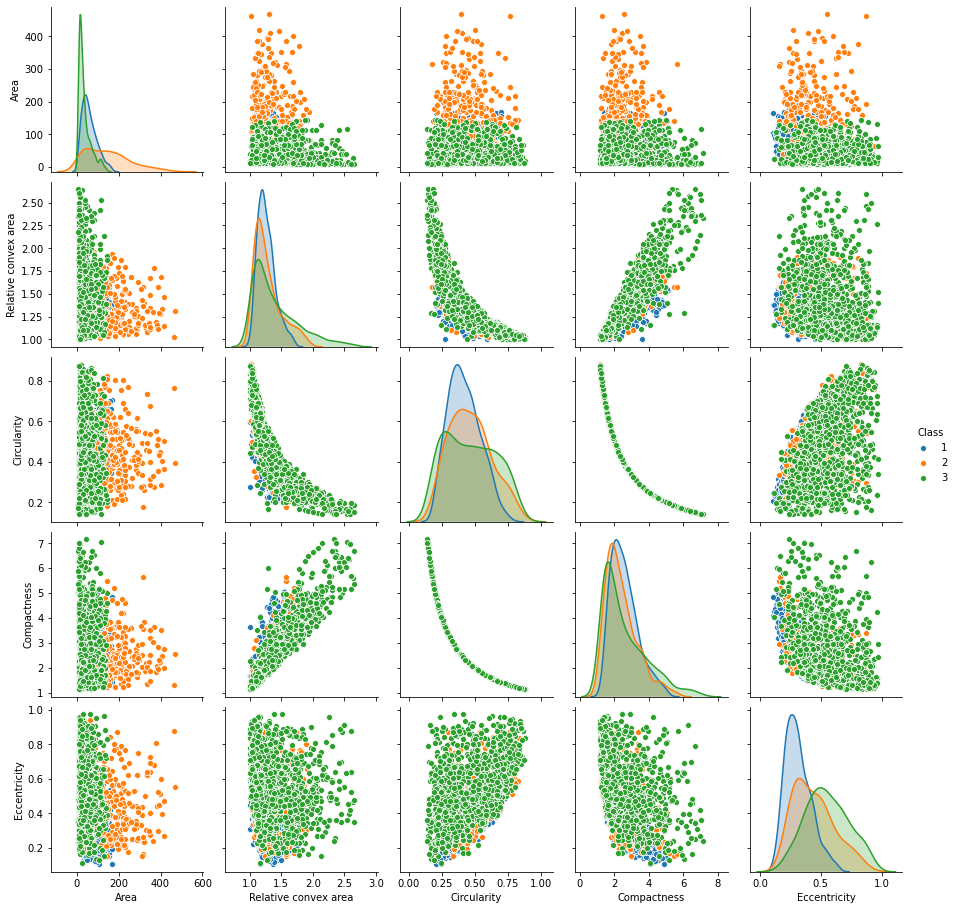

In [16]:
# Plotting pairplot of the filtered data matrix to observe the separability of classes wrt each feature

sns.pairplot(data_filt,hue="Class")

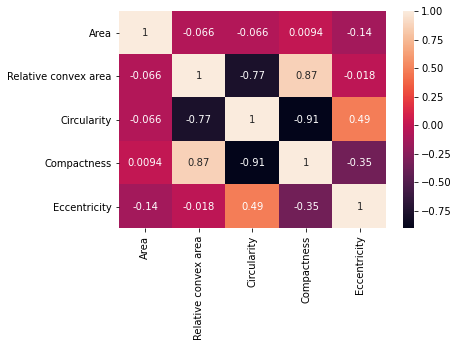

In [17]:
# Plotting the correlation map between the features of filtered data matrix to check the amount of correlation 
# between the features

data_corr = data_filt.corr()
sns.heatmap(data_corr,annot=True)

In [18]:
# Row labels and column labels of confusion matrix

rows_cf = ["Actual class-1","Actual class-2","Actual class-3"]
cols_cf = ["Predicted class-1","Predicted class-2","Predicted class-3"]

In [19]:
# X - Input feature matrix
X = data_filt.iloc[:,:-1]

# y - Class label vector of input features 
y = data_filt.iloc[:,-1]

# Splitting the data into train+validation and test data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform data balancing on the train+validation data using SMOTE to avoid any data imbalance between the classes
# before building the ML classifier
count_before = Counter(y_train_val)
print(count_before)
X_train_val, y_train_val = SMOTE().fit_resample(X_train_val, y_train_val)
count_after = Counter(y_train_val)
print(count_after)

# Further splitting the train+validation data into train data and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

Counter({'3': 837, '1': 676, '2': 271})
Counter({'2': 837, '1': 837, '3': 837})


In [20]:
# Building a decision tree classifier using train data

dt = DecisionTreeClassifier(max_depth=9,min_impurity_decrease=0.0).fit(X_train,y_train)
y_pred_train = dt.predict(X_train)
y_pred_val = dt.predict(X_val)
y_pred_test = dt.predict(X_test)

# Calculating and displaying all performance metrics of the above classifier

print("Classification report (train):\n", classification_report(y_train, y_pred_train))
print("Classification report (validation):\n", classification_report(y_val, y_pred_val))
print("Classification report (test):\n", classification_report(y_test, y_pred_test))
conf_mat_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train),index=rows_cf,columns=cols_cf)
print("Confusion matrix (train):\n",conf_mat_train)
conf_mat_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val),index=rows_cf,columns=cols_cf)
print("Confusion matrix (validation):\n",conf_mat_val)
conf_mat_test = pd.DataFrame(confusion_matrix(y_test,y_pred_test),index=rows_cf,columns=cols_cf)
print("Confusion matrix (test):\n",conf_mat_test)
dt.feature_importances_

Classification report (train):
               precision    recall  f1-score   support

           1       0.83      0.85      0.84       674
           2       0.81      0.86      0.83       659
           3       0.89      0.83      0.86       675

    accuracy                           0.84      2008
   macro avg       0.85      0.84      0.84      2008
weighted avg       0.85      0.84      0.84      2008

Classification report (validation):
               precision    recall  f1-score   support

           1       0.67      0.72      0.69       163
           2       0.74      0.70      0.72       178
           3       0.75      0.72      0.74       162

    accuracy                           0.72       503
   macro avg       0.72      0.72      0.72       503
weighted avg       0.72      0.72      0.72       503

Classification report (test):
               precision    recall  f1-score   support

           1       0.75      0.72      0.73       151
           2       0.43      

array([0.44143778, 0.11540666, 0.05640941, 0.03181627, 0.35492988])

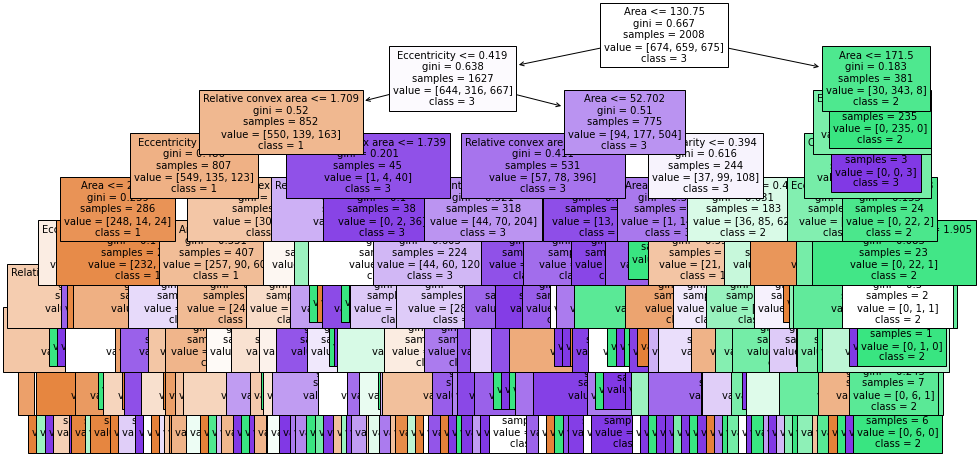

In [21]:
# Plotting the decision tree of the above decision tree classifier

fig,ax = plt.subplots(figsize=(15,8))
plot_tree(dt,feature_names = data_filt.columns[:-1],class_names = ["1","2","3"],filled=True,fontsize=10)
plt.show()

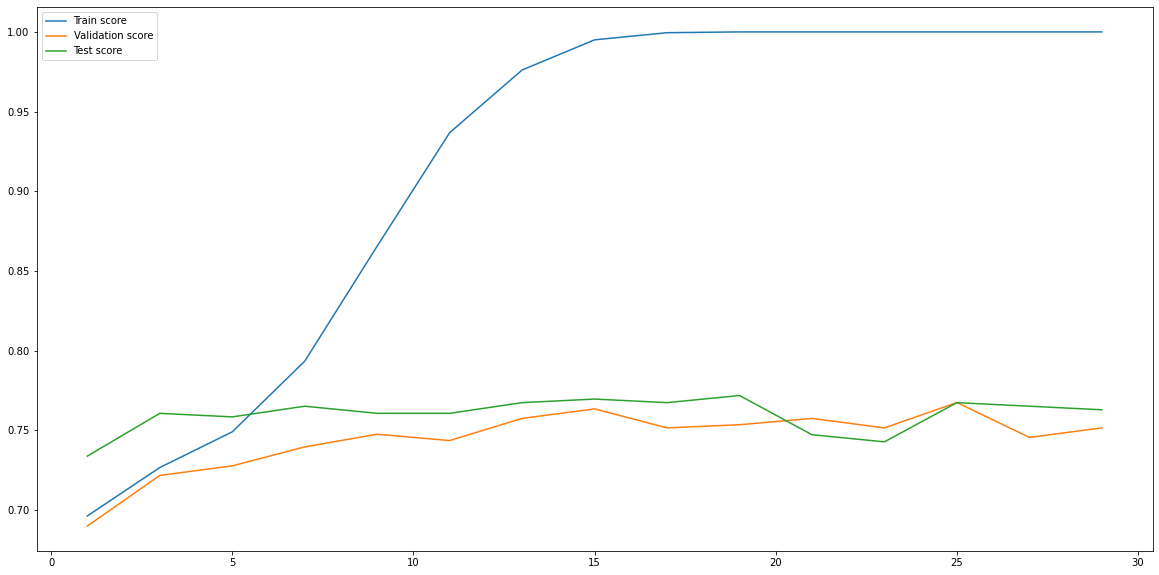

In [22]:
# Finding best max_depth hyperparameter value for random forest classifier based on the input data

max_depth_list = list(range(1,30,2))

train_scores = []
val_scores = []
test_scores = []

for max_depth in max_depth_list:
    rf_test1 = RandomForestClassifier(max_depth=max_depth).fit(X_train,y_train)
    y_pred_train = rf_test1.predict(X_train)
    y_pred_val = rf_test1.predict(X_val)
    y_pred_test = rf_test1.predict(X_test)
    train_score = f1_score(y_train, y_pred_train,average='micro')
    train_scores.append(train_score)
    val_score = f1_score(y_val, y_pred_val,average='micro')
    val_scores.append(val_score)
    test_score = f1_score(y_test, y_pred_test,average='micro')
    test_scores.append(test_score)
    
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(max_depth_list,train_scores)
ax.plot(max_depth_list,val_scores)
ax.plot(max_depth_list,test_scores)
ax.legend(["Train score", "Validation score", "Test score"])

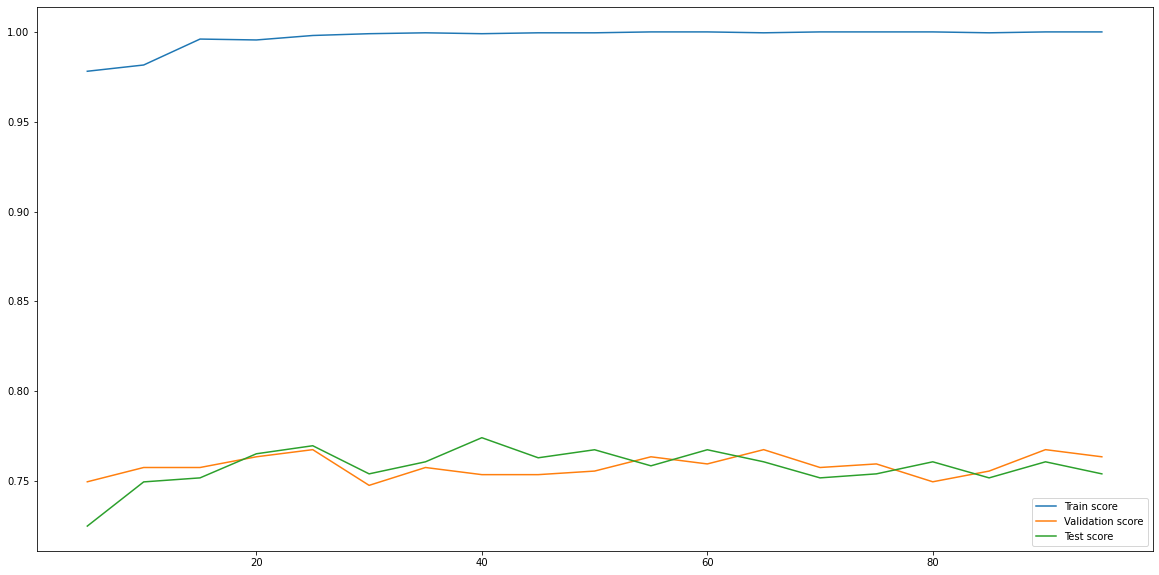

In [23]:
# Finding best number_of_estimators hyperparameter value for random forest classifier based on the input data

n_estimators_list = list(range(5,100,5))

train_scores = []
val_scores = []
test_scores = []

for n_estimators in n_estimators_list:
    rf_test2 = RandomForestClassifier(n_estimators=n_estimators).fit(X_train,y_train)
    y_pred_train = rf_test2.predict(X_train)
    y_pred_val = rf_test2.predict(X_val)
    y_pred_test = rf_test2.predict(X_test)
    train_score = f1_score(y_train, y_pred_train,average='micro')
    train_scores.append(train_score)
    val_score = f1_score(y_val, y_pred_val,average='micro')
    val_scores.append(val_score)
    test_score = f1_score(y_test, y_pred_test,average='micro')
    test_scores.append(test_score)
    
fig,ax = plt.subplots(figsize=(20,10))
ax.plot(n_estimators_list,train_scores)
ax.plot(n_estimators_list,val_scores)
ax.plot(n_estimators_list,test_scores)
ax.legend(["Train score", "Validation score", "Test score"])

In [24]:
# Building a random forest classifier using train data

rf = RandomForestClassifier(n_estimators=50,max_depth=9).fit(X_train,y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
y_pred_test = rf.predict(X_test)


# Calculating and displaying all performance metrics of the above classifier

print("Classification report (train):\n", classification_report(y_train, y_pred_train))
print("Classification report (validation):\n", classification_report(y_val, y_pred_val))
print("Classification report (test):\n", classification_report(y_test, y_pred_test))
conf_mat_train = pd.DataFrame(confusion_matrix(y_train,y_pred_train),index=rows_cf,columns=cols_cf)
print("Confusion matrix (train):\n",conf_mat_train)
conf_mat_val = pd.DataFrame(confusion_matrix(y_val,y_pred_val),index=rows_cf,columns=cols_cf)
print("Confusion matrix (validation):\n",conf_mat_val)
conf_mat_test = pd.DataFrame(confusion_matrix(y_test,y_pred_test),index=rows_cf,columns=cols_cf)
print("Confusion matrix (test):\n",conf_mat_test)
rf.feature_importances_

Classification report (train):
               precision    recall  f1-score   support

           1       0.80      0.92      0.86       674
           2       0.97      0.80      0.87       659
           3       0.86      0.88      0.87       675

    accuracy                           0.87      2008
   macro avg       0.87      0.86      0.87      2008
weighted avg       0.87      0.87      0.87      2008

Classification report (validation):
               precision    recall  f1-score   support

           1       0.67      0.81      0.74       163
           2       0.85      0.62      0.72       178
           3       0.76      0.83      0.79       162

    accuracy                           0.75       503
   macro avg       0.76      0.75      0.75       503
weighted avg       0.76      0.75      0.75       503

Classification report (test):
               precision    recall  f1-score   support

           1       0.72      0.78      0.75       151
           2       0.66      

array([0.40799856, 0.11906461, 0.09102011, 0.08459974, 0.29731698])

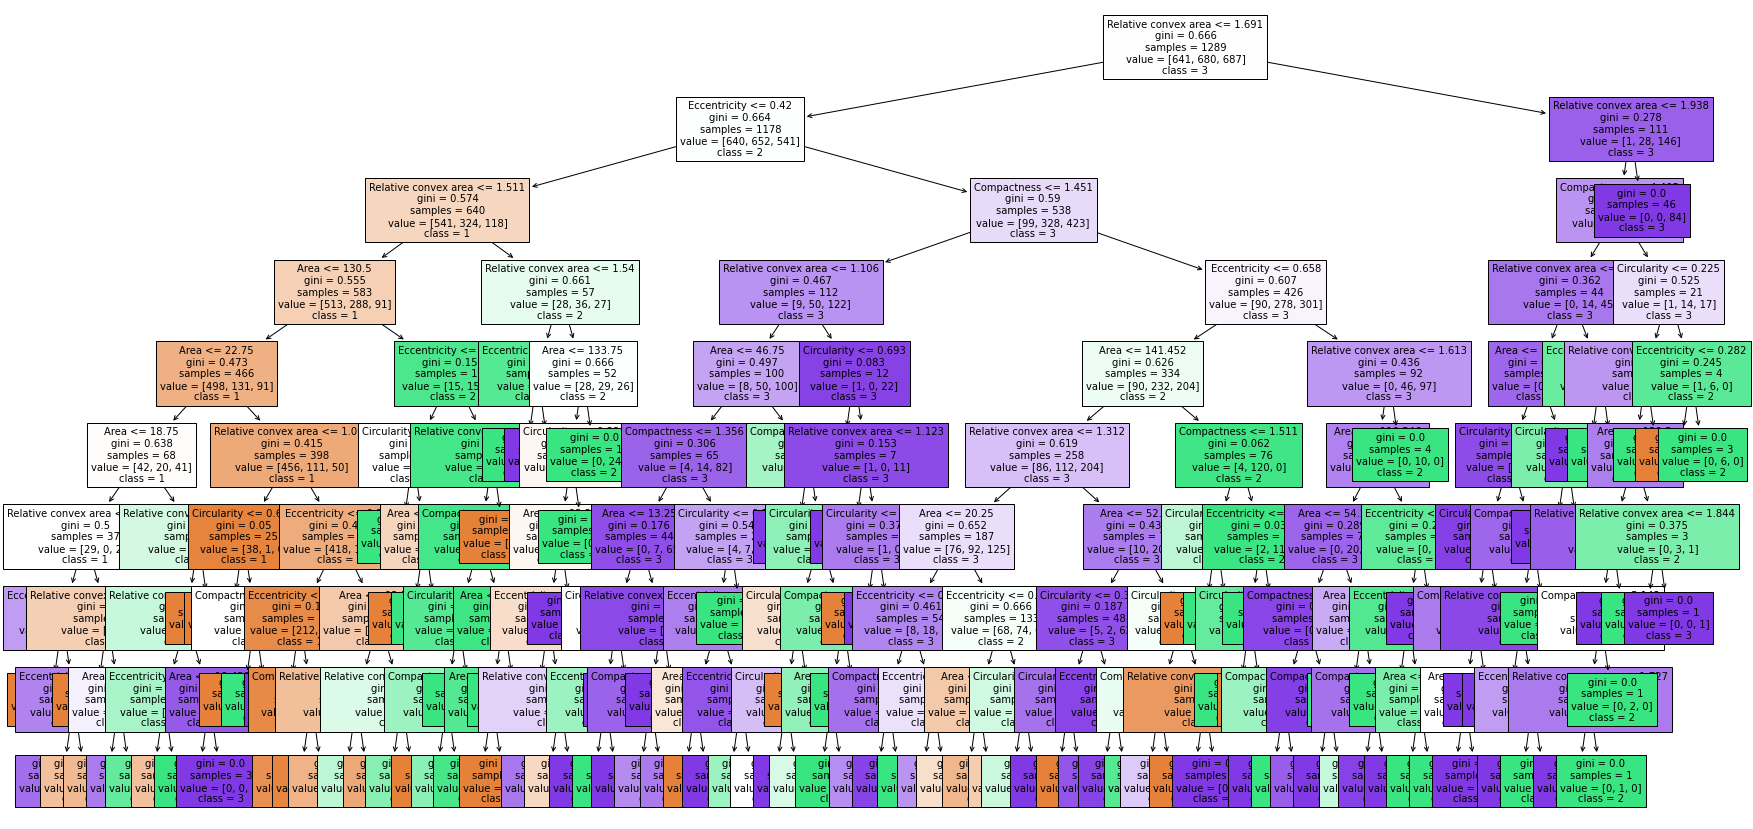

In [25]:
# Plotting one of the decision trees of the above random forest classifier

estimator = rf.estimators_[5]
fig,ax = plt.subplots(figsize=(30,15))
plot_tree(estimator,feature_names = data_filt.columns[:-1],class_names = ["1","2","3"],filled=True,fontsize=10)
plt.show()

# Testing part

In [34]:
# Reading the input image 
img_file_path = r"D:\Project\Data\pone.0218861.g007.tif"
orig_img = cv2.imread(img_file_path)
orig_img_shape = orig_img.shape
img = orig_img.copy()
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_th = cv2.threshold(img_gray,30,255,cv2.THRESH_BINARY_INV)
img_th_inv = 255-img_th


# Performing image segmentation on input image
img_seg = image_segmentation(img)

# Bitwise AND between segmented image and grayscale thresholded image to remove any bounding markers
# img_seg = cv2.bitwise_and(img_seg,img_th_inv)

# Resizing the segmented image to standard size of 600x800 for further processing
img_seg = cv2.resize(img_seg,(img_shape[1],img_shape[0]))


# Post processing on the segmented image
img_pp = image_postprocess(img_seg)
       

# Extracting the contours from the labelled image
contours,_ = cv2.findContours(img_pp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# Finding the contours of objects from the postprocessed labelled image
contours_filt = find_contours(img_pp)

# Initialization of empty pandas data frame with below columns to store data matrix
data_test = pd.DataFrame(columns = cols_data)

# Initialize a grayscale image with all zeros to draw all the contours
img_cnt = np.zeros(img_shape, np.uint8)


# Extract the geometric features of all the filtered contours
for cnt in contours_filt:
    features = extract_features(cnt)
    cnt_centre,area,roughness,rel_conv_area,eccentricity,circularity,compactness,eccentricity = features
    cls_lbl = None
    img_cnt = cv2.drawContours(img_cnt, [cnt], -1, 255, 3)

    # Append the features to input dataframe and form the data matrix     
    data_test = data_test.append({'Area' : area,  'Roughness' : roughness, 'Relative convex area':rel_conv_area, 
                                'Circularity':circularity, 'Compactness': compactness, 'Eccentricity':eccentricity, 
                                'Class' : cls_lbl}, ignore_index = True)

In [35]:
print(len(contours))
print(data_test.shape[0])
data_test.drop(["Roughness"],axis=1,inplace=True)

110
109


In [36]:
# X_final_test - Input feature matrix of test image

X_final_test = data_test.iloc[:,:-1]

# y_final_test = Predicted class labels using the random forest classifier trained above
y_final_test = rf.predict(X_final_test)

# Assigning the predicted class labels to the pandas test dataframe
data_test["Class"] = y_final_test

print(y_final_test)

['1' '1' '1' '1' '3' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '3'
 '1' '1' '3' '3' '1' '3' '1' '3' '1' '3' '1' '1' '1' '3' '3' '3' '1' '3'
 '1' '3' '1' '1' '1' '1' '3' '3' '3' '1' '1' '3' '3' '3' '3' '2' '3' '3'
 '3' '1' '1' '3' '2' '3' '1' '1' '1' '1' '1' '1' '1' '2' '1' '1' '1' '3'
 '3' '3' '1' '1' '1' '1' '1' '3' '3' '3' '1' '1' '1' '1' '1' '3' '3' '3'
 '1' '1' '1' '1' '1' '3' '1' '1' '1' '3' '3' '1' '1' '1' '3' '1' '1' '1'
 '2']


In [37]:
# Displaying the complete data matrix of test image

pd.set_option('display.max_rows',None)
data_test

,Area,Relative convex area,Circularity,Compactness,Eccentricity,Class
0,18.0,1.333333,0.388089,2.576730,0.275755,1
1,18.0,1.083333,0.497925,2.008333,0.211396,1
2,25.0,1.040000,0.561353,1.781411,0.395569,1
3,14.0,1.321429,0.347970,2.873815,0.218221,1
4,31.0,1.145161,0.607939,1.644902,0.424035,3
5,30.0,1.250000,0.372825,2.682227,0.235179,1
6,15.5,1.387097,0.309882,3.227038,0.253890,1
7,31.5,1.317460,0.419232,2.385316,0.306101,1
8,13.0,1.307692,0.389287,2.568802,0.342990,1
9,11.0,1.363636,0.281944,3.546798,0.216639,1


In [38]:
# Drawing bounding ellipses and rectangles across each contour of the test image where bounding ellipse indicates single bacillus,
# bounding rectangle indicates bacilli cluster and no bounding box indicates an artifact

img_bb = img_cnt.copy()  
for i in range(len(contours_filt)):
    cnt = contours_filt[i]
    (x_ell,y_ell),(ma,MA),angle = cv2.fitEllipse(cnt)
    x_rect,y_rect,w,h = cv2.boundingRect(cnt)
    if (data_test.iloc[i,-1]=='1'):
        #cv2.circle(img_bb,(int(x_ell),int(y_ell)),int(MA),255,3)
        cv2.ellipse(img_bb, (int(x_ell),int(y_ell)), (int(ma),int(MA)), int(angle), 0, 360, color=255, thickness=3) 
    elif (data_test.iloc[i,-1]=='2'):
        cv2.rectangle(img_bb, (x_rect, y_rect), (x_rect+w, y_rect+h), 255, 3)   

In [39]:
print(i)
print(len(contours_filt))
print(data_test.shape)

108
109
(109, 6)


In [40]:
# Detection and counting of single bacillus in all the bacilli clusters

num_sing_tb_list = []
for i in range(data_test.shape[0]):
    sing_tb_count = 0
    if (data_test["Class"][i]=="1"):
        sing_tb_count+=1
    elif (data_test["Class"][i]=="2"):
        cnt = contours_filt[i]
        sing_tb_count,defects = count_single_bacillus(cnt)
        sing_tb_count = max(1,sing_tb_count)
    num_sing_tb_list.append(sing_tb_count)
    
print(num_sing_tb_list)
print(f'Based on the concave points, no. of TB bacilli detected on given image are: {sum(num_sing_tb_list)}')

[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 5]
Based on the concave points, no. of TB bacilli detected on given image are: 80


Text(0.5, 0, 'Image with bounding boxes')

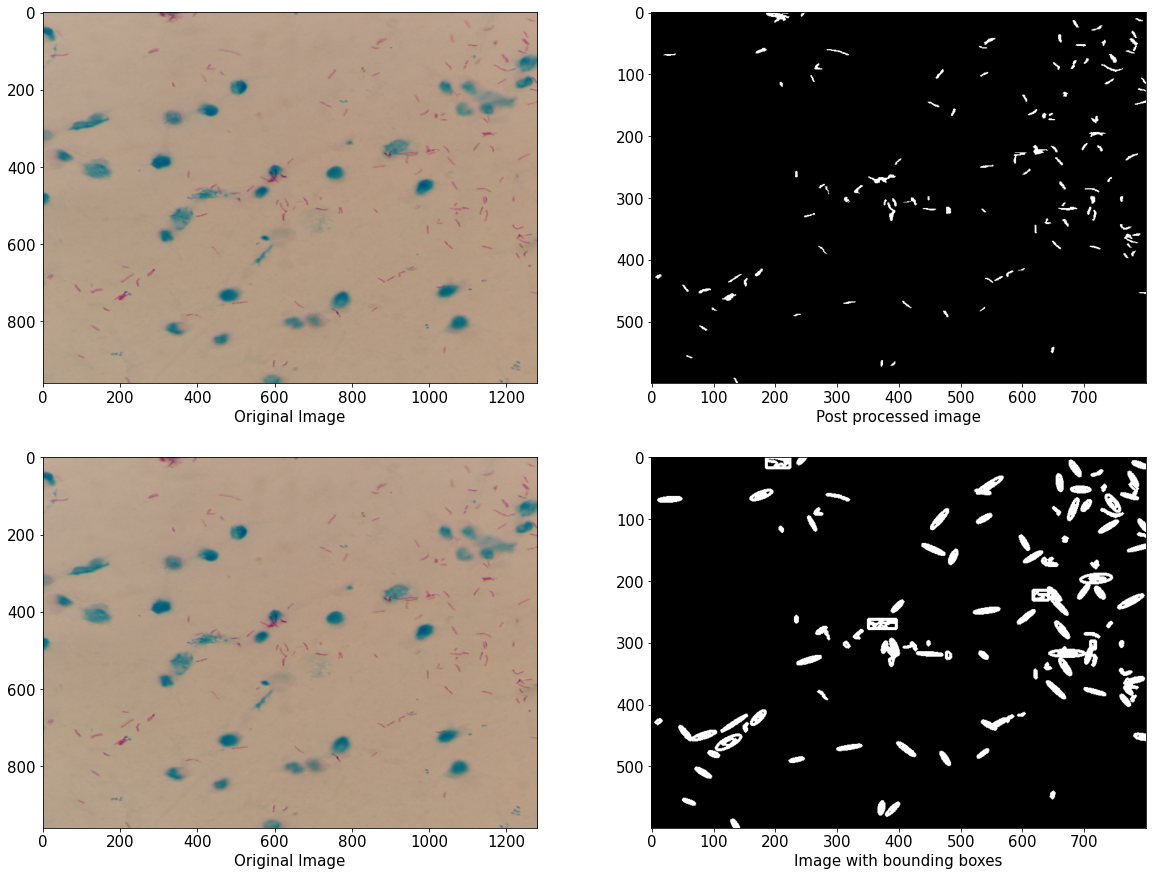

In [41]:
# Displaying original image, postprocessed image and image with contours and bounding boxes where the shape of bounding box
# across the contour indicates the type of bacilli i.e., single bacillus or bacilli cluster

matplotlib.rcParams.update({'font.size': 15})
fig,ax = plt.subplots(2,2,figsize=(20,15))
ax[0,0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
ax[0,0].set_xlabel("Original Image")
ax[0,1].imshow(img_pp, cmap='gray')
ax[0,1].set_xlabel("Post processed image")
ax[1,0].imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
ax[1,0].set_xlabel("Original Image")
ax[1,1].imshow(cv2.cvtColor(img_bb, cv2.COLOR_BGR2RGB))
ax[1,1].set_xlabel("Image with bounding boxes")